In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline 

<h1>MULTI-LAYER PERCEPTRON NEURAL NETWORK V3</h1>

inspiration: A Neural Probabilistic Language Model, Yoshua Bengio

character-level language model

modulating code and implementing diagnostic tools

In [5]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1D:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        # fields
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.batch_weight = torch.ones(dim)
        self.batch_bias = torch.zeros(dim)
        # buffers
        self.running_var = torch.ones(dim)
        self.running_mean = torch.zeros(dim)

    def __call__(self, x):

        # find var/mean of current batch (or running batch for inference/evaluation)
        if self.training:
            batch_mean = x.mean(0, keepdim=True)
            batch_var = x.var(0, keepdim=True, unbiased=True)
        else:
            batch_mean = self.running_mean
            batch_var = self.running_var

        x_hat = (x - batch_mean) / torch.sqrt(batch_var + self.eps) # normalized x
        self.out = self.batch_weight * x_hat + self.batch_bias # apply batch weight and bias

        # update running var/mean if training
        if self.training:
            with torch.no_grad():
                self.running_var = (1 - self.momentum) * self.running_var + (self.momentum) * batch_var
                self.running_mean = (1 - self.momentum) * self.running_mean + (self.momentum) * batch_mean

        return self.out

    def parameters(self):
        return [self.batch_weight, self.batch_bias]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [6]:
words = open("../data/names.txt", "r+").read().splitlines()
char_set = sorted(list(set(''.join(words) + '.'))) 
string_to_index = {char: ind for ind, char in enumerate(char_set)}
index_to_string = {ind: char for char, ind in string_to_index.items()}

In [7]:
block_size = 3


def build_dataset(words):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size
        for char in word + '.':
            X.append(context)
            Y.append(string_to_index[char])
            context = context[1:] + [string_to_index[char]]
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.shuffle(words)
n1, n2 = int(len(words) * 0.8), int(len(words) * 0.9) 
X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182414, 3]) torch.Size([182414])
torch.Size([22873, 3]) torch.Size([22873])
torch.Size([22859, 3]) torch.Size([22859])


In [10]:
n_embed = 10
n_hidden = 200
vocab_size = 27

C = torch.randn(vocab_size, n_embed)


layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(), 
    Linear(            n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(            n_hidden, vocab_size), BatchNorm1D(vocab_size),
]

with torch.no_grad():
    # make last layer less confident
    layers[-1].batch_weight *= 0.1
    # apply gain to all other linear layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

174751


In [13]:
max_steps = 200000
batch_size = 32
lossi = []
update_data_ratio = []

for i in range(max_steps):

    # construct batch
    indexes = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch, Y_batch = X_train[indexes], Y_train[indexes]

    # forward pass
    embed = C[X_batch]
    print(X_batch.shape)
    x = embed.view(embed.shape[0], -1)
    print(x.shape)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_batch)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    with torch.no_grad():
        update_data_ratio.append([((lr * p.grad.std()) / p.data.std()).log10().item() for p in parameters])

    # track
    lossi.append(loss.item())

    if i % 20000 == 0:
        print(f'{i:7d}/{max_steps}: loss = {loss.item():.4f}')
    if i == 1000:
        break


torch.Size([32, 3])
torch.Size([32, 30])
      0/200000: loss = 2.7761
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.Size([32, 30])
torch.Size([32, 3])
torch.S

layer 2 (Tanh): mean -0.01, std 0.63, saturation 2.84%
layer 5 (Tanh): mean 0.01, std 0.64, saturation 2.38%
layer 8 (Tanh): mean 0.01, std 0.64, saturation 2.34%
layer 11 (Tanh): mean -0.00, std 0.65, saturation 1.78%
layer 14 (Tanh): mean -0.00, std 0.65, saturation 1.88%


Text(0.5, 1.0, 'activation distribution')

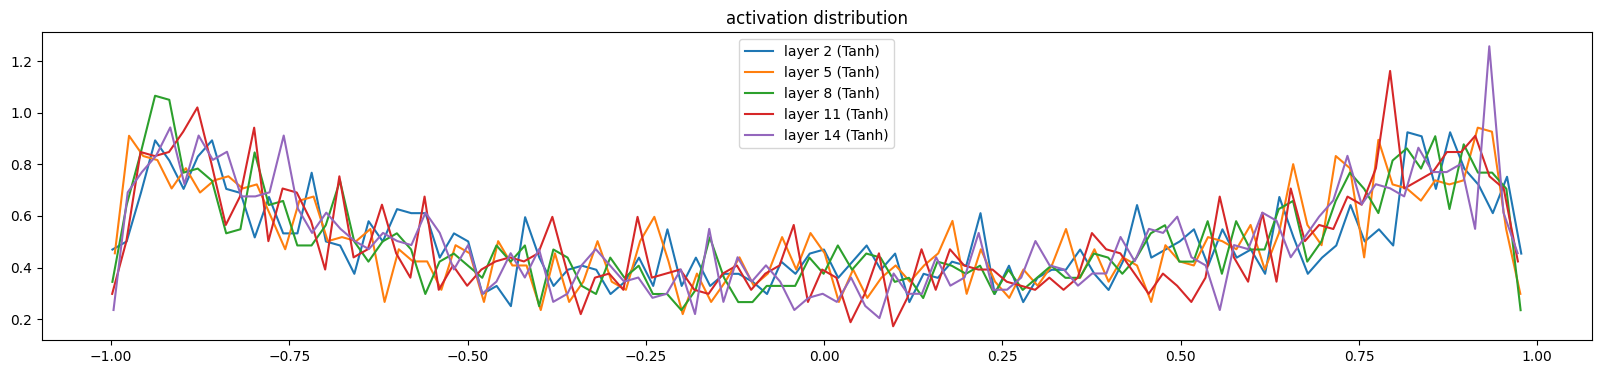

In [7]:
# visiualize histograms
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__}): mean {t.mean():.2f}, std {t.std():.2f}, saturation {(t.abs() > 0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (Tanh): mean -0.000000, std 3.421965e-03
layer 5 (Tanh): mean -0.000000, std 2.909785e-03
layer 8 (Tanh): mean +0.000000, std 2.684045e-03
layer 11 (Tanh): mean +0.000000, std 2.528099e-03
layer 14 (Tanh): mean -0.000000, std 2.522134e-03


Text(0.5, 1.0, 'gradient distribution')

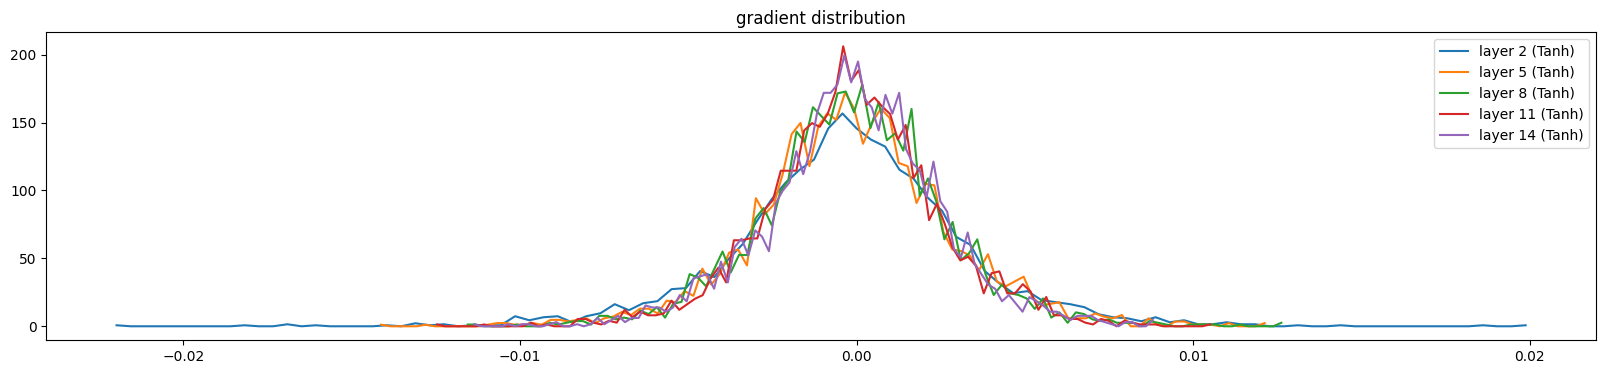

In [8]:
# visiualize histograms
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__}): mean {t.mean():+f}, std {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight (27, 10)   | mean +0.000000 | std 9.769198e-03 | grad: data ratio 0.010657313279807568
weight (30, 100)  | mean -0.000065 | std 8.357526e-03 | grad: data ratio 0.027694737538695335
weight (100, 100) | mean -0.000004 | std 7.197030e-03 | grad: data ratio 0.04258875548839569
weight (100, 100) | mean -0.000075 | std 6.201492e-03 | grad: data ratio 0.03730779513716698
weight (100, 100) | mean -0.000058 | std 5.721526e-03 | grad: data ratio 0.034085847437381744
weight (100, 100) | mean -0.000020 | std 5.527648e-03 | grad: data ratio 0.032979343086481094
weight (100, 27)  | mean -0.000172 | std 1.032477e-02 | grad: data ratio 0.06213066354393959


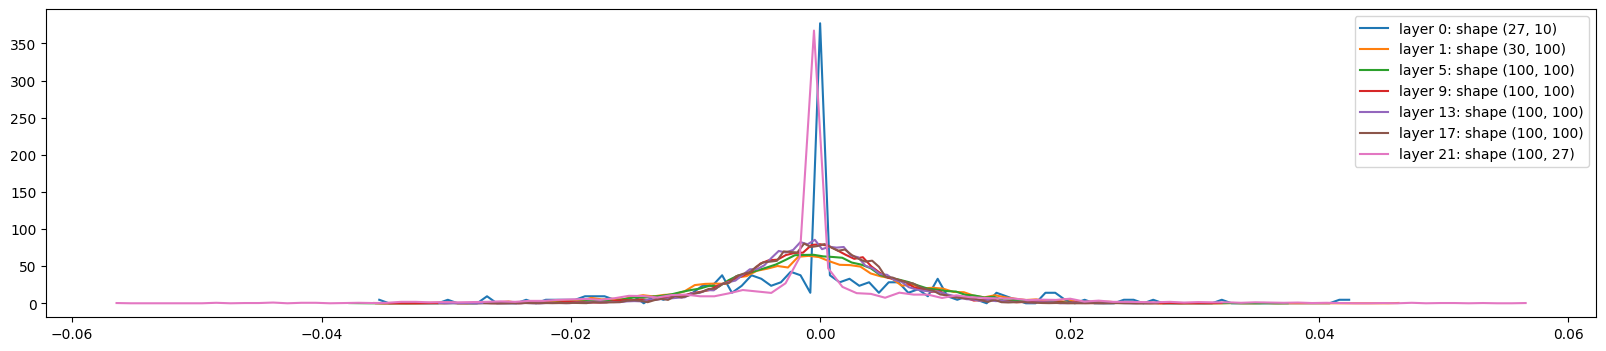

In [9]:
plt.figure(figsize=(20, 4))
legends = [] 
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f'weight {str(tuple(p.shape)):10} | mean {t.mean():+f} | std {t.std():e} | grad: data ratio {t.std() / p.std()}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i}: shape {str(tuple(p.shape))}')
    plt.legend(legends)




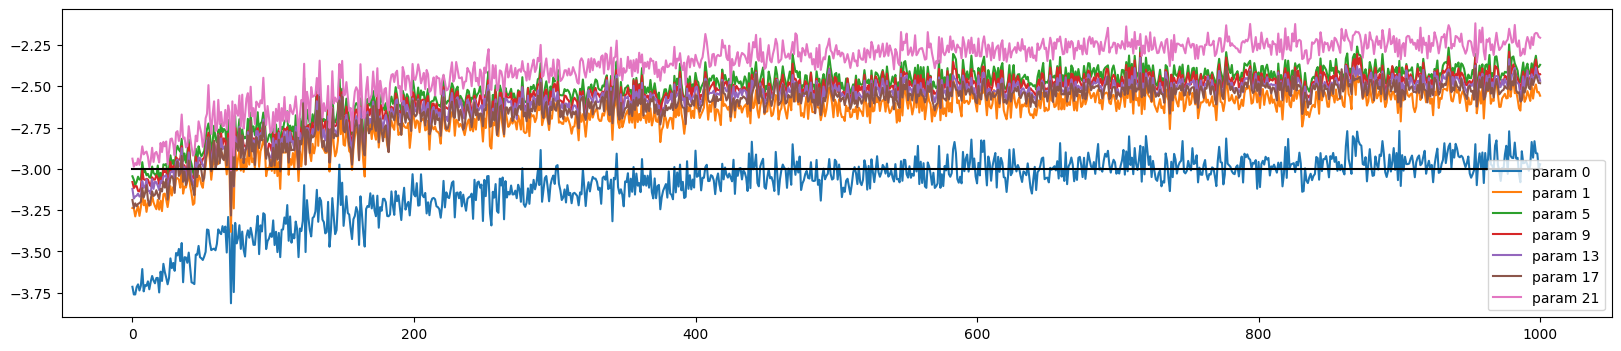

In [10]:
# linear ratios of current parameter weight versus update step through iterations
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([update_data_ratio[j][i] for j in range(len(update_data_ratio))])
        legends.append(f'param {i}')
plt.plot([0, len(update_data_ratio)], [-3, -3], 'k') # ideal ratio
plt.legend(legends)